
## **Project Abstract** ## 
To help people get started on their project and to make sure you are selecting an appropriate task, we will have all the teams submit an abstract. Please only submit one abstract per team.

The abstract should include (at least):

-Team members

-Problem statement

-Data you will use to solve the problem

-Outline of how you plan on solving the problem with the data. For example, what pre-processing steps might you need to do, what models, etc.

-Supporting documents if necessary citing past research in the area and methods used to solve the problem.

-The goal of this abstract is for you to think deeply about the project you will be undertaking and convince yourself (and us) that it is a meaningful and achievable project for this class.

This homework is due March 1, 2018 by midnight Utah time. and will be submitted on learning suite.

# Airbnb New User Bookings

## Team Members

- Alex Fabiano 
- Michael Clawson
- Elijah Broadbent 


## Problem Statement



With 34,000+ cities across 190+ countries, Airbnb users have a multitude of destinations from which to choose.  This vast array of possibilities creates problems for both users and Airbnb. New users may suffer choice overload and prolong their first booking. Irregular and prolonged first bookings can cause demand lags and inhibit demand predictability for Airbnb.
	
The goal of this data project is to accurately predict where new users will book their first Airbnb. This will enable Airbnb to share more personalized content and better forecast demand as well as improve user experience.


## Data

The data for this project comes from four separate files containing age and gender buckets, countries, websession, and a user set.  We will need to join the users and sessions sets into a training set while the remaining sets will serve as supplementary information to inform our data cleaning and analysis.

**Import Statements**

In [9]:
import pandas as pd
import numpy as np
import sklearn as sk
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
from sklearn.model_selection import train_test_split

In [10]:
test = pd.read_csv('test_users.csv')
XY_Age = pd.read_csv('age_gender_bkts.csv') #complicated and messy...consider doing last
countries = pd.read_csv('countries.csv')
users = pd.read_csv('train_users_2.csv')
sessions = pd.read_csv('sessions.csv')

Note that other refers to bookings made to a country not on this list while NDF corresponds to sessions in which no booking was ultimately made.

In [11]:
users.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US


In [12]:
sessions.head()

,user_id,action,action_type,action_detail,device_type,secs_elapsed
0,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,319.0
1,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,67753.0
2,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,301.0
3,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,22141.0
4,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,435.0


In [13]:
joined = pd.merge(users, sessions, left_on='id', right_on='user_id', how='inner')
joined.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,...,signup_app,first_device_type,first_browser,country_destination,user_id,action,action_type,action_detail,device_type,secs_elapsed
0,d1mm9tcy42,2014-01-01,20140101000936,2014-01-04,MALE,62.0,basic,0,en,sem-non-brand,...,Web,Windows Desktop,Chrome,other,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,319.0
1,d1mm9tcy42,2014-01-01,20140101000936,2014-01-04,MALE,62.0,basic,0,en,sem-non-brand,...,Web,Windows Desktop,Chrome,other,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,67753.0
2,d1mm9tcy42,2014-01-01,20140101000936,2014-01-04,MALE,62.0,basic,0,en,sem-non-brand,...,Web,Windows Desktop,Chrome,other,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,301.0
3,d1mm9tcy42,2014-01-01,20140101000936,2014-01-04,MALE,62.0,basic,0,en,sem-non-brand,...,Web,Windows Desktop,Chrome,other,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,22141.0
4,d1mm9tcy42,2014-01-01,20140101000936,2014-01-04,MALE,62.0,basic,0,en,sem-non-brand,...,Web,Windows Desktop,Chrome,other,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,435.0


## Data Cleaning and Feature Engineering

In [5]:
joined.country_destination.value_counts(normalize=True, dropna=False)

NDF      0.552137
US       0.302553
other    0.057993
FR       0.026392
IT       0.018373
ES       0.012130
GB       0.011743
CA       0.007096
DE       0.004224
NL       0.004075
AU       0.002169
PT       0.001114
Name: country_destination, dtype: float64

In [15]:
print("Joined Length: {}\tSessions Length: {}\tUsers Length: {}".format(len(joined), len(sessions), len(users)))

Joined Length: 5537957	Sessions Length: 10567737	Users Length: 213451


In [16]:
joined.dtypes

id                          object
date_account_created        object
timestamp_first_active       int64
date_first_booking          object
gender                      object
age                        float64
signup_method               object
signup_flow                  int64
language                    object
affiliate_channel           object
affiliate_provider          object
first_affiliate_tracked     object
signup_app                  object
first_device_type           object
first_browser               object
country_destination         object
user_id                     object
action                      object
action_type                 object
action_detail               object
device_type                 object
secs_elapsed               float64
dtype: object

In [17]:
# The following function locates the columns with null values and stores the column names in the 'null' array
def nulls():
    return joined.columns[joined.isnull().any()]

In [31]:
# Displays the columns with null values and the percent of null values for each column
print("Columns\t\t\t % Nulls")
joined[nulls()].isnull().sum()/len(joined)

Columns			 % Nulls


date_first_booking         0.552137
age                        0.381989
first_affiliate_tracked    0.000242
action                     0.009305
action_type                0.111929
action_detail              0.111929
secs_elapsed               0.013329
dtype: float64

Date of booking null values indicate that no booking was ever made, so it is not an issue with the dataset. Age is by far the most glaring issue with the data, and we are also missing almost half of the book dates. We may be able to find a way to fill the null values of age with the average ages dependent upon several other variables, ex: fill average ages of a female mac owners who use chrome.

**Date Account Created**

In [43]:
joined.date_account_created.describe() #Need to extract usable variables

count                 5537957
unique                    181
top       2014-06-09 00:00:00
freq                    58902
first     2014-01-01 00:00:00
last      2014-06-30 00:00:00
Name: date_account_created, dtype: object

In [35]:
joined.date_account_created = pd.to_datetime(joined.date_account_created) #Casts object as datetime

In [41]:
# Create indicators for day of week (0=Mon, 6=Sun) account was created
joined['day_of_week_created']= joined.date_account_created.dt.weekday
# Create indicators for day of month (0 through 31), month, and year account created
joined['day_of_month_created'] = joined['date_account_created'].dt.day
joined['month_created'] = joined['date_account_created'].dt.month
joined['year_created'] = joined['date_account_created'].dt.year

Do we really want date of first booking? It seems a bit silly to predict where people are booking when we already have the date. If we want to present something that's more realistic, we might want to try to predict based on historical info.

-- I think you make an excellent point...we should ask Tyler after class

**Date First Booking**

In [45]:
#Create variable for whether a user booked at all
joined['Booked?'] = np.where(joined['date_first_booking'].isnull(), 'False', 'True') 

In [50]:
joined.date_first_booking = pd.to_datetime(joined.date_first_booking)

In [51]:
joined['day_of_week_1stbook'] = joined['date_first_booking'].dt.weekday
joined['day_of_month_1stbook'] = joined['date_first_booking'].dt.day
joined['month_1stbook'] = joined['date_first_booking'].dt.month
joined['year_1stbook'] = joined['date_first_booking'].dt.year

In [142]:
#what can we intuit from the gender variable?
data_train['gender'].value_counts()

-unknown-    2083332
FEMALE       1291403
MALE         1049829
OTHER           5801
Name: gender, dtype: int64

Unknown should be kept as a variable, and should not try to fill, given that it is very likely that the model will see unknown genders in the test set. 

In [143]:
pd.get_dummies(data_train, prefix=['gender'], columns=['gender']) #Dummy variables for gender

,id,date_account_created,timestamp_first_active,date_first_booking,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,...,year_of_1stbook,Booked?,day_of_week_account_creation,day_of_month_account_creation,month_of_account_creation,year_of_account_creation,gender_-unknown-,gender_FEMALE,gender_MALE,gender_OTHER
5088629,3cc7j199j0,2014-06-21,20140621004357,2015-05-24,22.0,facebook,25,en,direct,direct,...,2015.0,True,5,21,6,2014,0,0,1,0
2808256,6wtccsozb1,2014-04-25,20140425115549,2014-05-22,NaN,basic,0,en,direct,direct,...,2014.0,True,4,25,4,2014,0,1,0,0
4744532,cl7ey4o79s,2014-06-12,20140612084632,2014-11-11,19.0,basic,0,en,sem-brand,google,...,2014.0,True,3,12,6,2014,1,0,0,0
89969,qsig176xlb,2014-01-05,20140105235301,NaT,22.0,basic,0,en,direct,direct,...,NaN,False,6,5,1,2014,0,1,0,0
1406618,w2zqw1xxyl,2014-03-05,20140305093523,NaT,NaN,basic,23,en,direct,direct,...,NaN,False,2,5,3,2014,1,0,0,0
3340832,q6oa8zogtp,2014-05-09,20140509041600,NaT,46.0,facebook,0,en,sem-brand,bing,...,NaN,False,4,9,5,2014,0,1,0,0
2079690,gg1cyr2vlf,2014-04-04,20140404033739,NaT,23.0,facebook,0,en,direct,direct,...,NaN,False,4,4,4,2014,0,0,1,0
1076471,lu6l1bgml8,2014-02-18,20140218162337,2014-02-25,22.0,basic,0,en,direct,direct,...,2014.0,True,1,18,2,2014,0,1,0,0
2202720,ufit580t57,2014-04-08,20140408043604,2014-04-24,NaN,basic,0,en,direct,direct,...,2014.0,True,1,8,4,2014,1,0,0,0
3623335,fkcnz11k27,2014-05-16,20140516023419,NaT,NaN,basic,23,en,direct,direct,...,NaN,False,4,16,5,2014,1,0,0,0


In [144]:
data_train.age.describe() #What are we dealing with in the age category?

count    2.737848e+06
mean     4.308509e+01
std      1.210366e+02
min      1.000000e+00
25%      2.700000e+01
50%      3.200000e+01
75%      4.100000e+01
max      2.014000e+03
Name: age, dtype: float64

There are some max values of 2014 for an age, which is rather odd.

In [145]:
print(sum(data_train.age > 122))
print(sum(data_train.age < 18))
#How many ages are completely nonsensical?

10564
2233


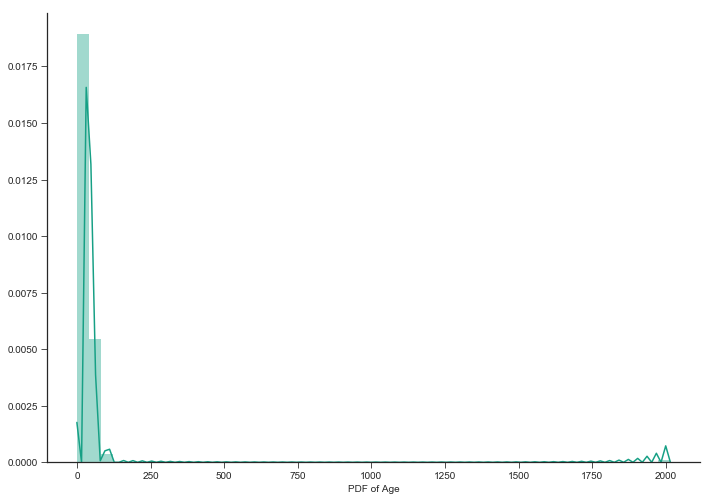

In [146]:
#How many individuals created accounts with unusable ages? What percent of our dataset is compromised? 
sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
sns.distplot(data_train.age.dropna(), color='#16A085')
plt.xlabel('PDF of Age')
sns.despine()

C:\Users\michael.clawson\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


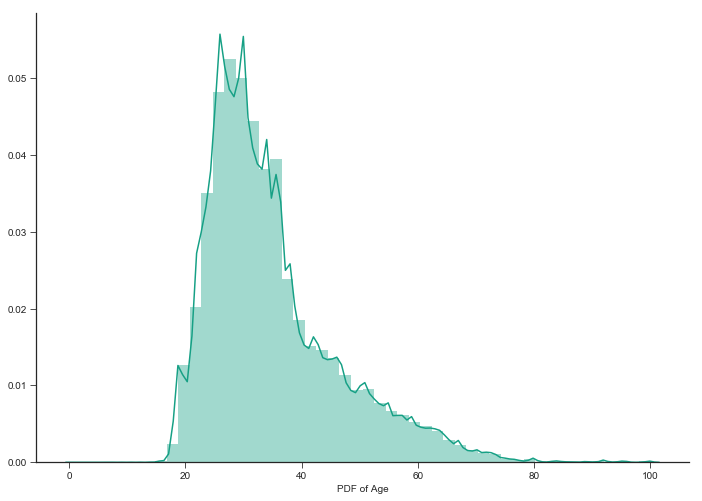

In [147]:
sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
data_train['normal_age']=data_train['age'].apply(lambda x : 36 if x>100 else x)
sns.distplot(data_train.normal_age.dropna(), color='#16A085')
plt.xlabel('PDF of Age')
sns.despine()

Most of our dataset is comprised of 25-40-year-olds, and there is a small subset of users that are younger than the Airbnb terms of service allow to book rooms.
However, we will have to do something about the weird ages in the thousands.

In [148]:
data_train = data_train.drop(['normal_age'], axis = 1)

In [149]:
#Change all unusable ages to NaN:
data_train.loc[data_train.age > 95, 'age'] = np.nan
data_train.loc[data_train.age < 13, 'age'] = np.nan

Will need to revisit age variable after we've looked at the other variables that we could possibly extrapolate more targeted age data from.

In [150]:
#What to do with signup method?
data_train['signup_method'].value_counts()

basic       3368110
facebook    1010522
google        51733
Name: signup_method, dtype: int64

Signup Method is a rather straightforward dummy case, and there are no null values to fill in for, as per the null value analysis done previously in the notebook.

In [151]:
pd.get_dummies(data_train, prefix=['signup_method'], columns=['signup_method']) #Dummy variables for signup_method
data_train = data_train.drop(['signup_method'], axis = 1)

In [152]:
data_train['signup_flow'].value_counts() #What is signup flow?

0     3340136
25     551079
12     209598
23     208738
24     115142
8        5525
21        147
Name: signup_flow, dtype: int64

In [153]:
#While still unsure as to what signup_flow is, it is not a continuous variable, so we can make dummies out of it.
pd.get_dummies(data_train, prefix=['signup_flow'], columns=['signup_flow']) #Dummy variables for signup_method
data_train = data_train.drop(['signup_flow'], axis = 1)

In [154]:
#Language should also be a clear-cut categorical variable, but let's look to be sure:
data_train['language'].value_counts()

en    4270056
zh      49736
ko      27320
fr      18837
es      17606
de      11161
it       7268
ru       7108
pt       6866
ja       5093
sv       2376
nl       1601
da       1001
fi        851
el        756
tr        724
pl        643
cs        443
th        316
id        190
no        145
hu        133
is         79
ca         56
Name: language, dtype: int64

In [155]:
#Dummy variables for language:
pd.get_dummies(data_train, prefix=['language'], columns=['language']) #Dummy variables for signup_method
data_train = data_train.drop(['language'], axis = 1)

In [124]:
users.first_affiliate_tracked.value_counts(dropna=False)
#Maybe make a binary variable, tracked versus untracked?  Fill NaN's according to probability
#numpy.random.choice()

untracked        109232
linked            46287
omg               43982
tracked-other      6156
NaN                6065
product            1556
marketing           139
local ops            34
Name: first_affiliate_tracked, dtype: int64

In [125]:
users.country_destination.value_counts(dropna=False)

NDF      124543
US        62376
other     10094
FR         5023
IT         2835
GB         2324
ES         2249
CA         1428
DE         1061
NL          762
AU          539
PT          217
Name: country_destination, dtype: int64

In [126]:
users.first_browser.value_counts(dropna=False)

Chrome                  63845
Safari                  45169
Firefox                 33655
-unknown-               27266
IE                      21068
Mobile Safari           19274
Chrome Mobile            1270
Android Browser           851
AOL Explorer              245
Opera                     188
Silk                      124
Chromium                   73
BlackBerry Browser         53
Maxthon                    46
IE Mobile                  36
Apple Mail                 36
Sogou Explorer             33
Mobile Firefox             30
SiteKiosk                  24
RockMelt                   24
Iron                       17
IceWeasel                  13
Pale Moon                  12
CometBird                  11
SeaMonkey                  11
Yandex.Browser             11
Camino                      9
TenFourFox                  8
CoolNovo                    6
wOSBrowser                  6
Avant Browser               4
Opera Mini                  4
Mozilla                     3
TheWorld B

We can make a dummy for each of these variables.

Dummies for the major browsers and then an other and an unknown category.  Could maybe group some of the google offshoots/Amazon Offshoots into a category.

In [127]:
users.first_device_type.value_counts(dropna=False)

Mac Desktop           89600
Windows Desktop       72716
iPhone                20759
iPad                  14339
Other/Unknown         10667
Android Phone          2803
Android Tablet         1292
Desktop (Other)        1199
SmartPhone (Other)       76
Name: first_device_type, dtype: int64

We can create dummies for desktop, Apple, Android, Microsoft, Phone, Android.

## Modeling

In [6]:
#Create train/test split
target = joined.country_destination
joined.drop(['country_destination'], axis=1, inplace=True)
xtrain, xtest, ytrain, ytest = train_test_split(joined, target, test_size=0.2, random_state=42)
print("%d items in training data, %d items in test data" % (len(xtrain), len(xtest)))

4430365 items in training data, 1107592 in test data


# Project Research

Based on the other Kaggle kernels for this project, a few different methods have been used to predict first booking location for new Airbnb users. Some competitors utilized the ensemble technique, incorporating up to three layers. One kaggler implemented a three tiered ensemble with six different models in each layer (Support Vector Machines, Logistic Regression, Random Forest, Gradient Boosting, Extra Trees Classifier, and K-Nearest Neighbors). Another kaggler coded a Normalized Discounted Cumulative Gain model, or NDCG, which is a type of ranking measure. This model relies on a logarithmic discounting factor and has achieved significant empirical results. However, little is known about the theoretical properties of NDCG models. Further information can be found at https://arxiv.org/abs/1304.6480 .

# Strategy

After merging our data and doing a minimal amount of initial cleaning, we will use a K-Neighbors Classifier to get a naive baseline for our classification problem.  From there we will modify our cleaning as needed to account for outliers, missing data, and optimal control variables in a more robust fashion.  Other models we plan to consult include Random Forest, regression, and Gradient Boosting.  Depending on the results we obtain from these methods we can complicate our approach using tiered-ensembles of multiple models.